In [4]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("photos_reduced"))

FAST_RUN = False
IMAGE_WIDTH=125
IMAGE_HEIGHT=125
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3


['Zwiebel_reduced', 'Kartoffel_reduced', 'Karotte_reduced']


In [5]:
# Pfade zu den Ordnern
folder_potato = 'photos_reduced/Kartoffel_reduced'
folder_onion = 'photos_reduced/Zwiebel_reduced'
folder_carrot = 'photos_reduced/Karotte_reduced'

# Initialisierung der Listen
categories = []
filenames = []

# Durchlaufen des Kartoffel-Ordners
for filename in os.listdir(folder_potato):
    categories.append(0)  # Kartoffel-Kategorie
    filenames.append(os.path.join(folder_potato, filename))

# Durchlaufen des Zwiebel-Ordners
for filename in os.listdir(folder_onion):
    categories.append(1)  # Zwiebel-Kategorie
    filenames.append(os.path.join(folder_onion, filename))

# Durchlaufen des Karotte-Ordners
for filename in os.listdir(folder_carrot):
    categories.append(2)  # Karotte-Kategorie
    filenames.append(os.path.join(folder_carrot, filename))

# Erstellung des DataFrames
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Ausgabe der ersten 5 Einträge des Dataframes
df.head()


,filename,category
0,photos_reduced/Kartoffel_reduced/Kartoffel (11...,0
1,photos_reduced/Kartoffel_reduced/Kartoffel (82...,0
2,photos_reduced/Kartoffel_reduced/Kartoffel (48...,0
3,photos_reduced/Kartoffel_reduced/Kartoffel (70...,0
4,photos_reduced/Kartoffel_reduced/Kartoffel (13...,0


<AxesSubplot:xlabel='category'>

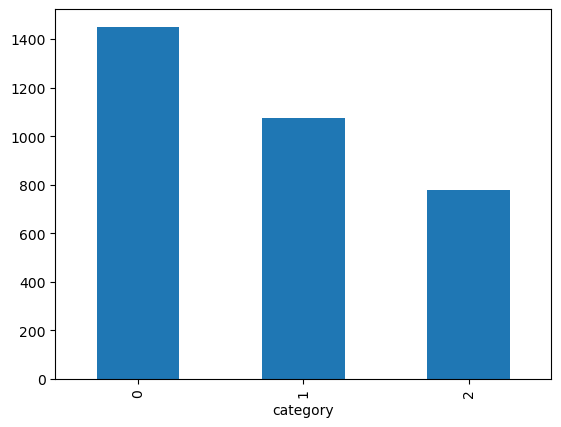

In [6]:
# Anzeigen der Gesamtzahl der Bilder in den Kategorien 
df['category'].value_counts().plot.bar()


(125, 125, 3)


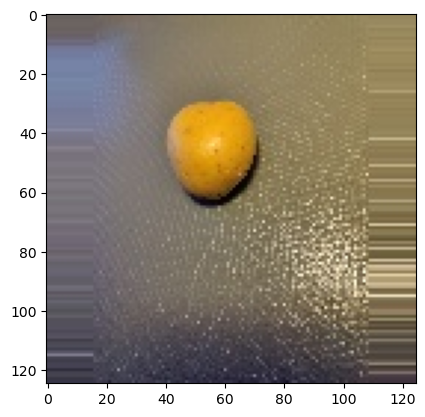

In [7]:
# Anzeigen eines zufälligen Bildes 
sample = random.choice(list(df['filename']))
image = load_img(sample)
print(np.asarray(image).shape)
plt.imshow(image)

In [8]:
# Ersetzen der Integer Werte für die Klasse durch einen String 
df["category"] = df["category"].replace({0: 'potato', 1: 'onion', 2: 'carrot'}) 

# Teilen der Daten in Traingsdaten und Validierungsdaten
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 10

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 Klassen (Kartoffel, Zwiebel, Karotte)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 123, 123, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 61, 61, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 59, 59, 64)        2

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
earlystop = EarlyStopping(patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
                                            
callbacks = [earlystop, learning_rate_reduction]

In [12]:
# Anwenden von Data Augmentation

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [13]:
# laden der Bilder in den Datengenerator
train_generator = train_datagen.flow_from_dataframe(
    train_df,  
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2645 validated image filenames belonging to 3 classes.


In [14]:
# Normieren der Bilder für die Validation 
validation_datagen = ImageDataGenerator(rescale=1./255)
# laden der Bilder in den Datengenerator
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 662 validated image filenames belonging to 3 classes.


Found 1 validated image filenames belonging to 1 classes.


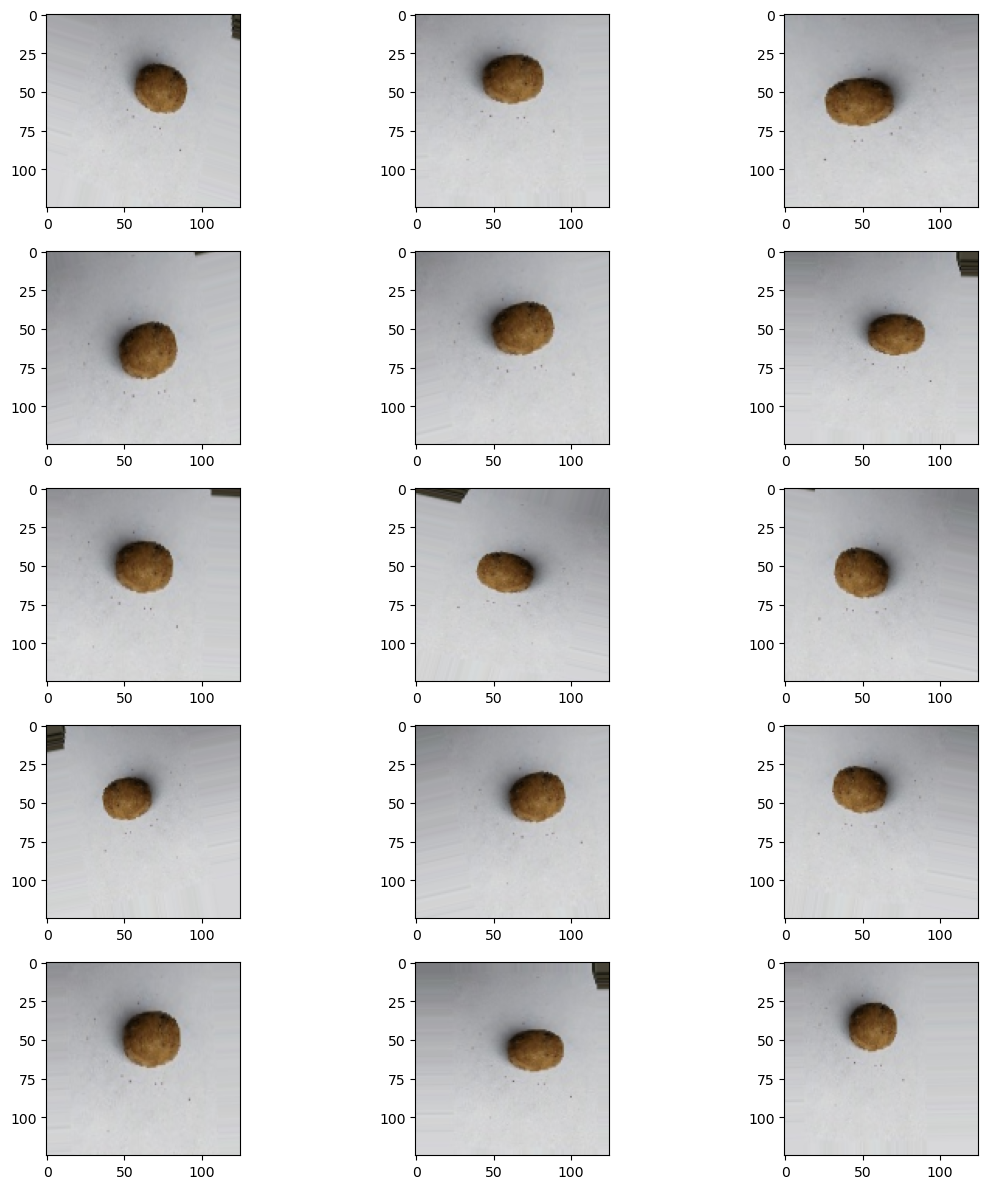

In [15]:
# Anzeigen der Bilder nach der Data Augmentation 
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)


plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
# Modelltraining
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)  


epochs = 5
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    callbacks=callbacks
)


# epochs = 5
# history = model.fit(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate // batch_size,
#     steps_per_epoch=total_train // batch_size,
#     callbacks=callbacks
# )


Epoch 1/5
265/265 [==============================] - 39s 146ms/step - loss: 0.9970 - accuracy: 0.6340 - val_loss: 1.3807 - val_accuracy: 0.5015 - lr: 0.0010
Epoch 2/5
265/265 [==============================] - 38s 142ms/step - loss: 0.5507 - accuracy: 0.7796 - val_loss: 1.4198 - val_accuracy: 0.4515 - lr: 0.0010
Epoch 3/5
265/265 [==============================] - 37s 141ms/step - loss: 0.4635 - accuracy: 0.8113 - val_loss: 1.3333 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 4/5
265/265 [==============================] - 38s 142ms/step - loss: 0.3829 - accuracy: 0.8461 - val_loss: 0.2884 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 5/5
265/265 [==============================] - 51s 194ms/step - loss: 0.3365 - accuracy: 0.8696 - val_loss: 0.8383 - val_accuracy: 0.6697 - lr: 0.0010
